# Observing surface water extent from space <img src="../fig/itc-logo@2x.png" alt="drawing" align = "right" width="50"/>


<b>Author</b>: [Amin Shakya](https://github.com/mn5hk), February, 2024

<b>Github link to the exercise files (base repository)</b>: https://github.com/ITC-Water-Resources/itc-hydrafloods-2024

<b>Credits</b>:

- [Mickey Maganini](https://github.com/mickymags) - slight updates to the course notebooks originally developed by Micky for the ITC course in 2023    
- [Kel Markert](https://github.com/KMarkert) - [troubleshoot](https://github.com/Servir-Mekong/hydra-floods/issues/48) for Landsat 8 data update on Google Earth Engine Data Catalog
- [Roelof Rietbroek](https://github.com/strawpants) - for his consultation on developing the tutorials

---

# Goal of the Study

<div class="alert alert-block alert-info">


In this notebook, we will look at how surface water extent can be detected from space. We first take a case study from <b>Tonle Sap, Indonesia</b> where surface water extent is being monitoed using the hydrafloods python package. The system is operationally used by NASA Servir - South East Asia to monitor the lake water extent change.<br><br>    
    In the following notebook, we apply the same ideas to a different case study for the flooding in Somalia in 2023. The students are strongly encouraged to play around with the module and to implement it in their case studies of choice.

</div>

<div class="alert alert-block alert-info">


In this notebook, we will look at how surface water extent in the Tonle Sap lake in Indonesia can be detected from space. More specifically, we will look at:

- What satellite earth observation data may help in detecting surface water extent from space?
- Pros and Cons: Optical imagery vs SAR imagery
- What algorithms can we use for surface water extent detection? 
- What applications may EO-based surface water extent be useful towards?
- Any caveats to be aware of?
- Further readings 

</div>

## Some theory

### Surface water mapping using optical imagery:
<img src = "../fig/donchytys_2016.png">
[extracted from Donchytys et al., (2016)]

[Donchytys et al., (2016): A 30 m Resolution Surface Water Mask Including Estimation of Positional and Thematic Differences Using Landsat 8, SRTM and OpenStreetMap: A Case Study in the Murray-Darling Basin, Australia]("https://www.mdpi.com/2072-4292/8/5/386#")

### Surface water mapping using SAR imagery:
<img src = "../fig/merkert_2020.png">
[extracted from Merkert et al., (2020)]

[Merkert et al., (2020): Comparing Sentinel-1 Surface Water Mapping Algorithms and Radiometric Terrain Correction Processing in Southeast Asia Utilizing Google Earth Engine]("https://www.mdpi.com/2072-4292/12/15/2469#")

<a id="00"></a>
___
## 00. Install python libraries (if not already installed)

In this step, we will install the python libraries we use in this exercise (if required). For now, let's proceed with [Step 1](#01).

Let's first try to run [Step 1](#01), where we try to import the modules, namely [ee](https://github.com/snare/ee), [geemap](https://github.com/gee-community/geemap), and [hydrafloods](https://github.com/Servir-Mekong/hydra-floods), that we use in this notebook. In case, [Step 1](#01) does not work, uncomment (a part of) this section, and rerun [Step 0](#00) and [Step 1](#01). If interested to learn more about these modules, brief intro to each module is provided in [further resources: python packages used](#packages).

In [1]:
# !pip install ee
# !pip install hydrafloods
# !pip install geemap

<a id="01"></a>
___
## 01. Import Python libraries and initialize Google Earth Engine

### 01a. Import python libraries

In [2]:
# from IPython.display import IFrame

In [3]:
import geemap
import geemap.colormaps as cm
import ee
import hydrafloods as hf
from hydrafloods import corrections

<div class="alert alert-block alert-info">
    <b>Alert:</b> ❓ Did the above step work correctly? If yes, please continue further with the notebook.
</div>


<div class="alert alert-block alert-warning">
    <b>Warning:</b> ⚠️ In case the above step did not work correctly (showed some error), check the error.  <br> 
    A common error in importing modules in python is that the modules do not exist in the python environment. If the error indeed is along the lines of <u><i>module not found</i></u>, revert back to [Step 0](#00) and install the missing module. To install a module, the following syntax may be useful:<br>
    <u><i>!pip install module-name</i></u>
</div>


### 01b. Authenticate Google Earth Engine

<div class="alert alert-block alert-info">
    <b>Alert:</b> ⓘ In this step, we authenticate our <a href = "https://code.earthengine.google.com">Google Earth Engine</a> account and initialize our earth engine account. To proceed further, you must have created a Google Earth Engine account. In case you do not have an Earth Engine account or have problem accessing the account. contact course instructors.
    </div>

In [4]:
ee.Authenticate()
ee.Initialize()

<div class="alert alert-block alert-info">
    <b>Alert:</b> ⓘIn case you could successfully authenticate your Google Earth Engine account, <b>congratulations</b>. We now move on further with the script.<br>
    </div>

<div class="alert alert-block alert-warning">
    <b>Warning:</b> ⚠️In case you have problems with <a href = "https://code.earthengine.google.com">Google Earth Engine</a> account authentication, check out <a href = "https://github.com/gee-community/geemap/issues/1018">this nice instruction</a> on the same by <a href = "https://github.com/giswqs">Qiusheng Wu</a>. You may also contact the course instructors for the same.
    </div>

### 01c. Initialize [geemap](https://github.com/gee-community/geemap), and check [hydrafloods](https://github.com/Servir-Mekong/hydra-floods) version

In this step, we first initialize [geemap](https://github.com/gee-community/geemap). [Geemap](https://github.com/gee-community/geemap) is an interactive python package great at Google Earth Engine data visualization (<i>and much more!</i>).

In [5]:
_ = geemap.Map()

We further check the version number of the [hydrafloods](https://github.com/Servir-Mekong/hydra-floods) python package.

In [6]:
hf.__version__

'2023.10.14'

<div class="alert alert-block alert-info">
    <b>Alert:</b> ⓘThis notebook is developed for the <a href = "https://github.com/Servir-Mekong/hydra-floods">hydrafloods</a> module version <i>2023.10.14</i>. In case your <a href = "https://github.com/Servir-Mekong/hydra-floods">hydrafloods</a> version is not the same, some minor changes to the script may be necessary.
    </div>

---
## 02. Define region of interest, time period

<div class="alert alert-block alert-info">
    <b>Alert:</b> ⓘTonle Sap in Cambodia is the largest lake in South-east Asia, with ecological importance <a href = "https://cambodia.wcs.org/saving-wild-places/tonle-sap-lake-floodplain.aspx">[source]</a>. <a href = "https://www.nasa.gov/servir/servir-southeast-asia/">NASA Servir South-east Asia</a> has an active <a href = "https://github.com/Servir-Mekong/hydra-floods">hydrafloods</a> model to monitor the changes in the lake.
    </div>

<div style="display: flex;">
    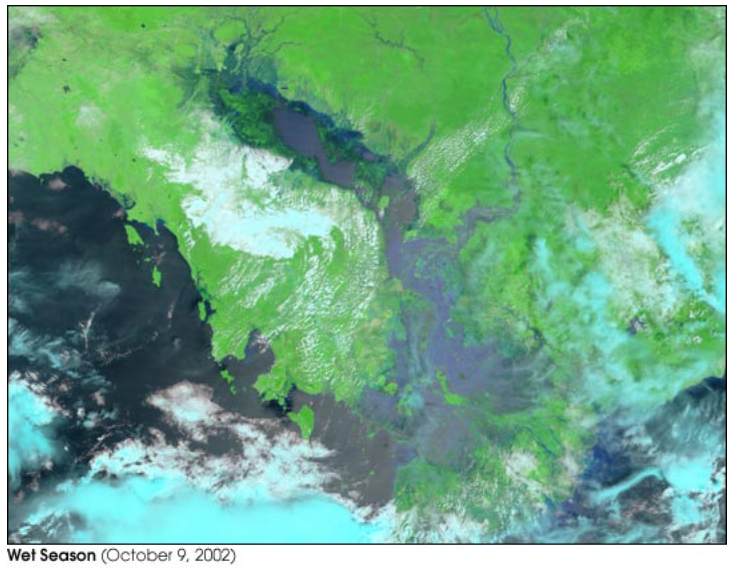
    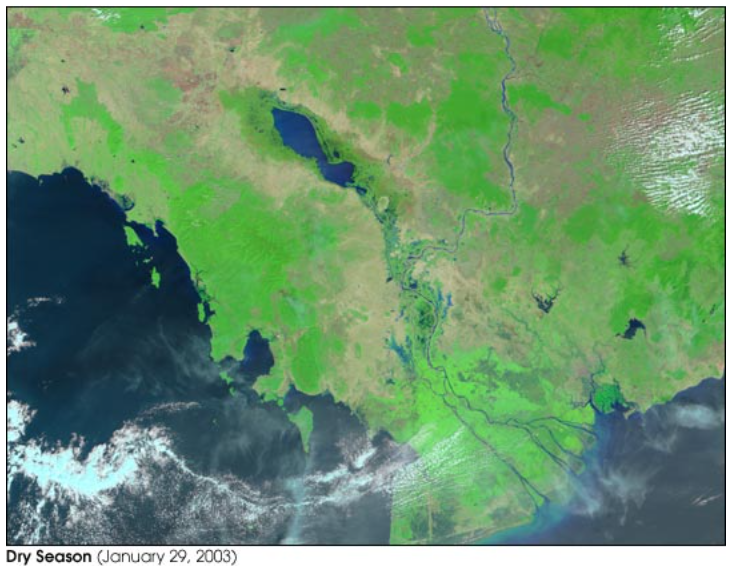
</div>


<center><b>Fig: Tonle Sap wet season (on the left) vs Tonle Sap dry season (on the right)</b> <a href = "https://cambodia.wcs.org/saving-wild-places/tonle-sap-lake-floodplain.aspx">[source]</a><br>
    <u><i>Notice the difference in water extent!</i></u></center>

<div class="alert alert-block alert-info">
    <b>Alert:</b> ⓘThis notebook is calibrated to the Tonle Sap study region, and has been made available with support of <a href="https://github.com/mickymags">Micky Maganini, NASA Servir</a>.
    </div>

### 02a. Define study region of interest

In [7]:
#Define the region of interest
tonlesap = ee.Geometry.Polygon([
        [106.40316, 11.7778],
        [106.40316, 13.6104],
        [103.56869, 13.6104],
        [103.56869, 11.7778]
    ])


### 02b. Define start and end time

In [8]:
#Define time period of interest
start_date = "2021-09-26"
end_date = "2021-10-15"

---
# Working with Earth Observation data

<div class="alert alert-block alert-info">
    <b>Alert:</b> ❓ What satellites may allow us to detect surface water change?
</div>


<div class="alert alert-block alert-info">
    <b>Discussion:</b> ❓ Pros and cons of using optical satellites vs SAR satellites for surface water extent detection?
</div>


<div class="alert alert-block alert-info">
    <b>Alert:</b> ❓ What algorithms may be useful in detecting surface water extent using Earth-Observation datasets?
</div>


> Some commonly used indices (optical) include water indices (<b>NDWI, MNDWI</b>, etc). Threshold algorithms such as <b>Edge-Otsu algorithm</b> are also useful!

> Approach: Use either <b>Optical</b> or <b>SAR</b> image collection (set of images); apply necessary corrections; reduce the image collection to an image (eg: take mean, median, etc); apply a thresholding algorithm on the reduced image to classify water or no water; Visualize/export

## 03. Optical Imagery Workflow

### 03a. Acquire optical data using hf.dataset

In [9]:
#Acquire optical data using hf.dataset
optical = hf.Landsat8(tonlesap, start_date, end_date)

##### Apply a function to rename some parameters

<div class="alert alert-block alert-info">
    <b>Alert:</b> ⓘLandsat 8 data recently got updated in Google Earth Engine, with a change in variable names. This change is not reflected in the current hydraflood version. As such, a quick fix is presented here. <br><br>Students are advised to not focus much on this step. Nonetheless, it does show practical issues with programming in general.</a>.
    </div>

In [10]:
# Update after consultation with Kel Markert via Github
# function to rename the sun angle properties to what is expected by
# the illumination_correction function
def rename_sunangle_properties(image):
    sz = ee.Number(90).subtract(image.get('SUN_ELEVATION'))
    sa = image.get('SUN_AZIMUTH')
    return image.set({"SOLAR_ZENITH_ANGLE": sz, "SOLAR_AZIMUTH_ANGLE": sa})

# apply the function to rename properties
optical = optical.apply_func(rename_sunangle_properties)

### 03b. Apply illumination correction

##### Acquire DEM data

Please note that users have a choice of DEM in this step.

In [11]:
elv = ee.Image("JAXA/ALOS/AW3D30/V2_2").select("AVE_DSM").unmask(0) #JAXA ALOS DEM
# merit_dem = ee.Image("MERIT/Hydro/v1_0_1").select("elv").unmask(0) #Merit-Hydro DEM: A hydrologically-adjusted DEM from Yamakazi, D. et al. 2019

In [12]:
opt_corrected = optical.apply_func(hf.corrections.illumination_correction, elevation = elv, scale=180) #Use JAXA DEM
# opt_corrected = optical.apply_func(hf.corrections.illumination_correction, elevation = dem, scale=180) #Use MERIT-Hydro DEM



### 03c. Apply a reducer

<div class="alert alert-block alert-info">
    <b>Discussion:</b> ❓ Which reducer is more appropriate: mean or median?
</div>


In [13]:
opt_reduced = opt_corrected.collection.median()
# opt_reduced = opt_corrected.collection.mean()
# opt_reduced = opt_corrected.collection.mosaic()
# opt_reduced = opt_corrected.collection.first()
# opt_reduced = opt_corrected.collection.last()

### 03c* Visualize (intermediatory) results

In [14]:
opt_params = {
    "min": 50,
    "max": 5500,
    "bands": "red,green,blue",
    "gamma":1.5,
    "dimensions": 1024
}

In [15]:
Map = geemap.Map(center = (12.7, 105), zoom = 8)
Map.addLayer(tonlesap, {}, 'Region of Interest')
Map.addLayer(opt_reduced, opt_params, 'Optical Imagery')
Map.addLayerControl()
Map

Map(center=[12.7, 105], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

### 03d Thresholding

In [16]:
#Optical thresholding

mndwi = opt_corrected.apply_func(hf.add_indices, indices = ["mndwi"])

mndwi_reduced = mndwi.collection.median()

opt_water = hf.edge_otsu(
    mndwi_reduced,
    "mndwi",
    initial_threshold = 0,
    thresh_no_data = 0.5,
    edge_buffer = 300,
    scale = 1e3,
    invert = True,
    region = tonlesap
)

### 03d* Visualization

In [17]:
water_params = {
    "min": 0,
    "max": 1,
    "palette": ['D3D3D3', '000080']
}

Map = geemap.Map(center = (12.7, 105), zoom = 9)

Map.addLayer(tonlesap, {}, 'Region of Interest')
Map.addLayer(opt_water.selfMask(), water_params, 'Optical-detected Water')

Map.addLayerControl()
Map

Map(center=[12.7, 105], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

---

## 04. SAR Imagery Workflow

### 04a. Acquire optical data using hf.dataset

In [18]:
#Acquire SAR data using hf.dataset
sar = hf.Sentinel1(tonlesap, start_date, end_date)

### 04b. Apply some corrections (Speckle filter)

#### Acquire DEM data

> Already acquired before (and can still be accessed for the SAR workflow (03b))

In [19]:
sar_speckle_filt = sar.apply_func(hf.gamma_map)

sar_corrected = sar_speckle_filt.apply_func(corrections.slope_correction, elevation = elv, buffer = 30)

### 04c. Apply a reducer

In [20]:
sar_reduced = sar_corrected.collection.median()

### 04c* Visualize (intermediatory step)    

In [21]:
sar_params = {
    "min": -25,
    "max": 0,
    "bands": "VV",
    "gamma": 1,
    "dimensions": 1024
}

In [22]:
Map = geemap.Map(center = (12.7, 105), zoom = 8)

Map.addLayer(tonlesap, {}, 'Region of Interest')
Map.addLayer(sar_reduced, sar_params, 'SAR Imagery')

Map.addLayerControl()
Map

Map(center=[12.7, 105], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

### 04d Thresholding

In [23]:
sar_water = hf.edge_otsu(
    sar_reduced,
    "VV",
    initial_threshold = -11,
    thresh_no_data = -20,
    edge_buffer = 300,
    region = tonlesap,
    scale = 1e3)

### 04d* Visualization

In [24]:
water_params = {
    "min": 0,
    "max": 1,
    "palette": ['D3D3D3', '000080']
}

Map = geemap.Map(center = (12.7, 105), zoom = 9)

Map.addLayer(tonlesap, {}, 'Region of Interest')
Map.addLayer(sar_water.selfMask(), water_params, 'SAR-detected Water')

Map.addLayerControl()
Map

Map(center=[12.7, 105], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

## 05 Compare visualization: Optical vs SAR

In [25]:
water_params_lightblue = {
    "min": 0,
    "max": 1,
    "palette": ['D3D3D3', '0000FF']
}

water_params_darkblue = {
    "min": 0,
    "max": 1,
    "palette": ['D3D3D3', '000080']
}

#https://geemap.org/notebooks/04_split_panel_map/
left_layer = geemap.ee_tile_layer(opt_water, water_params_lightblue, 'Optical-detected Water')
right_layer = geemap.ee_tile_layer(sar_water, water_params_darkblue, 'SAR-detected Water')

Map = geemap.Map(center = (12.7, 105), zoom = 8)
Map.split_map(left_layer, right_layer)
Map.addLayer(tonlesap, {}, 'Region of Interest')
Map

Map(center=[12.7, 105], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

In [26]:
#https://geemap.org/notebooks/04_split_panel_map/
left_layer = geemap.ee_tile_layer(opt_water.selfMask(), water_params_lightblue, 'Optical-detected Water')
right_layer = geemap.ee_tile_layer(sar_water.selfMask(), water_params_darkblue, 'SAR-detected Water')

Map = geemap.Map(center = (12.7, 105), zoom = 8)
Map.split_map(left_layer, right_layer)
Map.addLayer(tonlesap, {}, 'Region of Interest')
Map

Map(center=[12.7, 105], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

---
## 05. Further resources

- Spatial thoughts: https://spatialthoughts.com/courses/gee-for-water-resources-management/ 
- GEEMap: https://geemap.org/notebooks/41_water_app/
- Hydrafloods: https://servir-mekong.github.io/hydra-floods/
- GIS Opencourseware: https://ocw.un-ihe.org/mod/book/tool/print/index.php?id=11194
- Earth Engine Python API: https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api
- Surface Water Mapping tutorial: https://google-earth-engine.com/Aquatic-and-Hydrological-Applications/Surface-Water-Mapping/

<a id="packages"></a>
### Python packages used

- [ee](https://github.com/snare/ee) - Python API for Google Earth Engine, made by Google https://developers.google.com/earth-engine/guides/python_install
- [geemap](https://github.com/gee-community/geemap) - Alternative python package to work with Google Earth Engine, made by [Quisheng Wu](https://github.com/giswqs) https://geemap.org/
- [hydrafloods](https://github.com/Servir-Mekong/hydra-floods) - Surace water mapping python package built on top of Google Earth Engine, by NASA Servir Mekong https://servir-mekong.github.io/hydra-floods/